In [17]:
%matplotlib inline

## Make cut on subhalo mass at $M_{\rm peak} >= 10^{11.25}M_{\odot}$

In [79]:
from halotools.sim_manager import CachedHaloCatalog, UserSuppliedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

metadata = dict(Lbox=halocat.Lbox, 
               particle_mass=halocat.particle_mass, 
               redshift=halocat.redshift)

subhalo_mpeak_cut = 10**11.75
mvir_cut = 10**11.25
mask = halocat.halo_table['halo_mpeak'] > subhalo_mpeak_cut
mask *= halocat.halo_table['halo_mvir'] > mvir_cut

halo_catalog_columns = {key: halocat.halo_table[key][mask] for key in halocat.halo_table.keys()}
halo_catalog_columns.update(metadata)
halocat = UserSuppliedHaloCatalog(**halo_catalog_columns)

In [80]:
from halotools.empirical_models import ZuMandelbaum15Cens, ZuMandelbaum15Sats

threshold = 9.5
cens_hod = ZuMandelbaum15Cens(threshold=threshold, prim_haloprop_key='halo_mpeak', redshift=0)
sats_hod = ZuMandelbaum15Sats(threshold=threshold, prim_haloprop_key='halo_mpeak', redshift=0)

In [81]:
from csmf_from_hod import StellarMassFromHOD
csmf_centrals = StellarMassFromHOD('centrals', cens_hod.threshold, cens_hod)
csmf_satellites = StellarMassFromHOD('satellites', cens_hod.threshold, cens_hod)
csmf_satellites._suppress_repeated_param_warning = True

In [82]:
from segregated_nfw_phase_space import SegregatedNFWPhaseSpace
seg_nfw = SegregatedNFWPhaseSpace(prim_haloprop_key='halo_mpeak')

In [95]:
from halotools.empirical_models import SubhaloPhaseSpace
host_haloprop_bins = np.logspace(11.25, 15.15, 12)
d = dict(halo_id=('halo_id', 'i8'), halo_mpeak=('halo_mpeak', 'f8'))
satellites_mpeak = SubhaloPhaseSpace('satellites', host_haloprop_bins,
                                        inherited_subhalo_props_dict=d)

In [96]:
from halotools.empirical_models import TrivialPhaseSpace
cens_profile = TrivialPhaseSpace()

In [97]:
model_dictionary = dict(centrals_occupation=cens_hod, 
                       centrals_profile=cens_profile, 
                       centrals_stellar_mass=csmf_centrals, 
                       satellites_occupation=sats_hod, 
                       satellites_mpeak=satellites_mpeak, 
                       satellites_stellar_mass=csmf_satellites, 
                       satellites_profile=seg_nfw)

In [98]:
from halotools.empirical_models import HodModelFactory
model = HodModelFactory(**model_dictionary)

In [99]:
model.populate_mock(halocat)

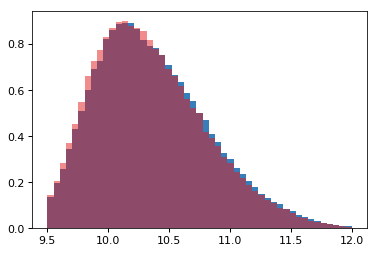

In [100]:
from halotools.empirical_models import ZuMandelbaum15SmHm
zu_mandelbaum = ZuMandelbaum15SmHm()

bsm = zu_mandelbaum.mc_stellar_mass(prim_haloprop=halocat.halo_table['halo_mpeak'], redshift=0)
beh_mask = bsm > 10**model.threshold
beh_mpeak = halocat.halo_table['halo_mpeak'][beh_mask]
beh_sm = bsm[beh_mask]


fig, ax = plt.subplots(1, 1)

logsm_bins = np.linspace(model.threshold, 12, 50)
__=ax.hist(np.log10(beh_sm), bins=logsm_bins, normed=True, color=blue)
__=ax.hist(np.log10(model.mock.galaxy_table['stellar_mass']), bins=logsm_bins, normed=True, 
          color=red, alpha=0.5)

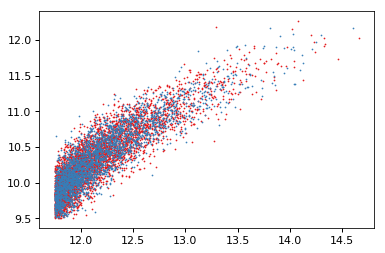

In [101]:
fig, ax = plt.subplots(1, 1)

x = np.log10(beh_mpeak)
y = np.log10(beh_sm)
len(beh_sm), len(beh_mask)

x2 = np.log10(model.mock.galaxy_table['halo_mpeak'])
y2 = np.log10(model.mock.galaxy_table['stellar_mass'])
__=ax.scatter(x2[::50], y2[::50], s=0.5, color=red)
__=ax.scatter(x[::50], y[::50], s=0.5, color=blue)


In [102]:
np.log10(host_haloprop_bins)

array([ 11.25      ,  11.60454545,  11.95909091,  12.31363636,
        12.66818182,  13.02272727,  13.37727273,  13.73181818,
        14.08636364,  14.44090909,  14.79545455,  15.15      ])